In [1]:
import os
import sys
sys.path.append('../va_pipeline/')
import json
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import string
import torch

%matplotlib inline
from calculate_accuracy import *
# from drawbox import *
from process import *
from sensor import exec_file



In [ ]:
cap = cv2.VideoCapture('../samples/testing/videos/largefast.mp4')


In [81]:
# test_dir = '../samples/testing/videos/'

# cap = cv2.VideoCapture(os.path.join(test_dir, 'large_slow.mp4'))

model = torch.hub.load('ultralytics/yolov5', 'yolov5n')
model.conf = 0.6 # NMS confidence threshold
model.max_det = 100  # maximum number of detections per image

# ret, prev = cap.read()
# frame_no = 1

# outputs = []

# while frame_no <= 250:
#     ret, frame = cap.read()

#     if not ret:
#         break
    
#     outputs.append(model(frame, size=(960, 540)).pandas().xywh[0])
#     frame_no += 1

# # df[vid] = diffs
# outputs = pd.concat(outputs)
# cap.release()

frame = cv2.imread('../samples/misc/golden.jpeg')

output = model(frame).pandas().xywh[0]


Using cache found in C:\Users\adamf/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-26 Python-3.9.13 torch-2.0.1+cpu CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


In [82]:
print(output)

Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: []


In [83]:
average_size = 0
for row in outputs.iterrows():
    average_size += (row[1][2] * row[1][3])
    
print(average_size/len(outputs))

NameError: name 'outputs' is not defined

In [ ]:
columns = ['Video', 'Width (px)', 'Height (px)', 'Frame Rate (fps)', 'frames', 'runtime (inference)',\
    'average time per frame', 'runtime (total)', 'energy', 'avg power', 'energy per frame', \
        'mAP', 'Resolution (px)', 'Resolution (1000s of px)', 'Energy (1000s of J)',
       'Energy (J) per frame', 'Detections', 'Average detection size']

# Energy & mAP

In [63]:
file = './test_results/config_testing/resolution/'
stats = 'stats/'
column_order = ['Video', 'Width (px)', 'Height (px)', 'Frame Rate (fps)']
dfs = []

def get_average_size(df_path, x_res, y_res):
    average_size = 0
    df = pd.read_csv(df_path, index_col=0)
    
    for row in df.iterrows():
        average_size += (row[1][2] * row[1][3])
    
    average_size /= len(df)
    
    return average_size


for video in list(os.listdir(os.path.join(file, 'stats/'))):
    file_name = '_'.join(os.path.splitext(video)[0].split('_')[0:-1]) # Get file name
    stats = os.path.join(file, 'stats/', file_name + '_stats.txt')
    inference = os.path.join(file, 'inference/', file_name + '_inference.csv')
    energy = os.path.join(file, 'energy/', file_name + '_energy.csv')

    df = pd.read_csv(stats, \
            sep=': ', header=None, engine='python').set_index(0)
    df = df.transpose().reset_index(drop=True)

    config_params = os.path.basename(stats).split('_')
    
    if config_params[0] in ['large3', 'large5'] or int(config_params[3]) != 5:
        continue
    # if int(config_params[3]) == 25:
    #     continue
    
    # Setting columns based on params
    df['Video'] = f'{config_params[0]}_{config_params[1]}_{config_params[2]}'
    df['Width (px)'], df['Height (px)'], df['Frame Rate (fps)'] = \
    config_params[1], config_params[2], config_params[3]
    df = df.astype({'Width (px)': int, 'Height (px)': int})

    # Add columns
    df['Resolution (px)'] = df['Width (px)'].multiply(df['Height (px)'])
    df['Resolution (1000s of px)'] = df['Resolution (px)'] / 1000
    df['Energy (1000s of J)'] = df['energy'] / 1000
    df['Energy (J) per frame'] = df['energy'] / 250

    # Count # of detections
    with open(inference, 'r') as f:
        lines = f.readlines()
        df['Detections'] = len(lines) - 1  # subtract the first line, which is cols of df
    
    # Average object size
    df['Average detection size'] = get_average_size(inference, df['Width (px)'], df['Height (px)'])
                
    df = df.reindex(columns=column_order+[x for x in df.columns if x not in column_order])
    dfs.append(df)

out = pd.concat(dfs)

In [64]:
out

,Video,Width (px),Height (px),Frame Rate (fps),frames,frames processed,runtime (inference),average time per frame,runtime (total),energy,avg power,energy per frame,mAP,Resolution (px),Resolution (1000s of px),Energy (1000s of J),Energy (J) per frame,Detections,Average detection size
0,large4_640_360,640,360,5,250.0,51.0,29.783858,0.119135,48.488762,220.041639,4.537992,0.880167,0.294913,230400,230.4,0.220042,0.880167,249,76460.376065
0,large4_960_540,960,540,5,250.0,51.0,59.251097,0.237004,85.653778,405.774964,4.737385,1.623100,0.374657,518400,518.4,0.405775,1.623100,239,74546.314302
0,largeslow2_640_360,640,360,5,250.0,51.0,30.392390,0.121570,49.196264,219.821046,4.468247,0.879284,0.845565,230400,230.4,0.219821,0.879284,1202,39074.859600
0,largeslow2_960_540,960,540,5,250.0,51.0,60.199806,0.240799,79.839053,383.423995,4.802462,1.533696,0.675294,518400,518.4,0.383424,1.533696,1437,29317.369818
0,largeslow_640_360,640,360,5,250.0,51.0,30.710509,0.122842,49.631154,227.243875,4.578654,0.908976,0.645981,230400,230.4,0.227244,0.908976,627,53150.118581
0,largeslow_960_540,960,540,5,250.0,51.0,60.078842,0.240315,79.429527,395.138026,4.974699,1.580552,0.457577,518400,518.4,0.395138,1.580552,617,51589.930472
0,medium_640_360,640,360,5,250.0,51.0,30.615659,0.122463,49.363908,222.351504,4.504334,0.889406,0.196221,230400,230.4,0.222352,0.889406,476,8960.086469
0,medium_960_540,960,540,5,250.0,51.0,59.167163,0.236669,78.678620,383.355421,4.872422,1.533422,0.393059,518400,518.4,0.383355,1.533422,693,7211.095674
0,noisy_640_360,640,360,5,250.0,51.0,30.103794,0.120415,48.812983,217.214064,4.449924,0.868856,0.254916,230400,230.4,0.217214,0.868856,1600,6922.748259
0,noisy_960_540,960,540,5,250.0,51.0,60.292437,0.241170,89.746994,423.650884,4.720502,1.694604,0.353105,518400,518.4,0.423651,1.694604,2274,5703.441802


In [65]:
out.columns

Index(['Video', 'Width (px)', 'Height (px)', 'Frame Rate (fps)', 'frames',
       'frames processed', 'runtime (inference)', 'average time per frame',
       'runtime (total)', 'energy', 'avg power', 'energy per frame', 'mAP',
       'Resolution (px)', 'Resolution (1000s of px)', 'Energy (1000s of J)',
       'Energy (J) per frame', 'Detections', 'Average detection size'],
      dtype='object', name=0)

<Axes: xlabel='Video'>

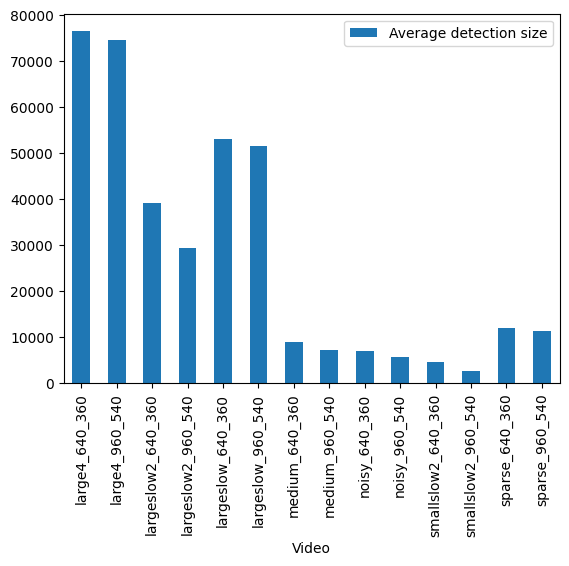

In [66]:
out.plot.bar('Video', 'Average detection size')

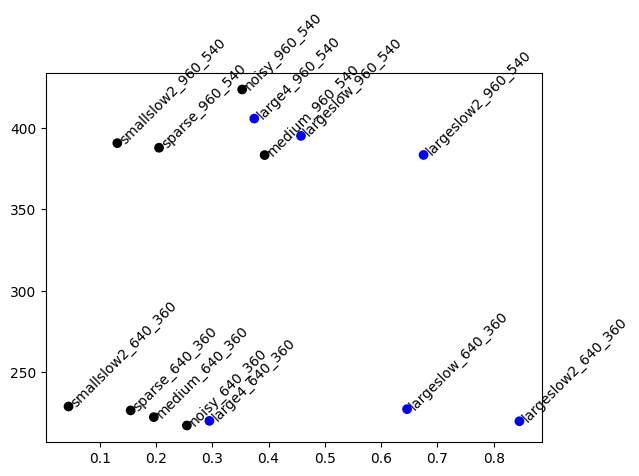

In [69]:
#create scatter plot of assists vs. points
col = np.where(out['Average detection size'] < 20000, 'k', np.where(out['Average detection size'] > 20000,'b','r'))
fig, ax = plt.subplots()

ax.scatter(out['mAP'], out['energy'], c=col)
# ax.scatter(out['Width (px)'], out['mAP'], c=col)
# ax.scatter(out['mAP'], out['energy'])

# ax.scatter(out['Resolution (px)']/1000, out['energy'])
# ax.set_title('Resolution and Energy Consumption')

#label each point in scatter plot
for idx, row in out.iterrows():
    ax.annotate(row['Video'], (row['mAP'], row['energy']), rotation=45)

# Framerate

In [2]:
file = './test_results/config_testing/framerate/'
stats = 'stats/'
column_order = ['Video', 'Width (px)', 'Height (px)', 'Frame Rate (fps)']
dfs = []

def get_average_size(df_path, x_res, y_res):
    average_size = 0
    df = pd.read_csv(df_path, index_col=0)
    
    for row in df.iterrows():
        average_size += (row[1][2] * row[1][3])
    
    average_size /= len(df)
    
    return average_size


for video in list(os.listdir(os.path.join(file, 'stats/'))):
    file_name = '_'.join(os.path.splitext(video)[0].split('_')[0:-1]) # Get file name
    stats = os.path.join(file, 'stats/', file_name + '_stats.txt')
    inference = os.path.join(file, 'inference/', file_name + '_inference.csv')
    energy = os.path.join(file, 'energy/', file_name + '_energy.csv')

    df = pd.read_csv(stats, \
            sep=': ', header=None, engine='python').set_index(0)
    df = df.transpose().reset_index(drop=True)

    config_params = os.path.basename(stats).split('_')

    if int(config_params[3]) == 25:
        continue
    
    # Setting columns based on params
    df['Video'] = f'{config_params[0]}_{config_params[3]}'
    df['Width (px)'], df['Height (px)'], df['Frame Rate (fps)'] = \
    config_params[1], config_params[2], config_params[3]
    df = df.astype({'Width (px)': int, 'Height (px)': int})

    # Add columns
    df['Resolution (px)'] = df['Width (px)'].multiply(df['Height (px)'])
    df['Resolution (1000s of px)'] = df['Resolution (px)'] / 1000
    df['Energy (1000s of J)'] = df['energy'] / 1000
    df['Energy (J) per frame'] = df['energy'] / 250

    # Count # of detections
    with open(inference, 'r') as f:
        lines = f.readlines()
        df['Detections'] = len(lines) - 1  # subtract the first line, which is cols of df
    
    # Average object size
    df['Average detection size'] = get_average_size(inference, df['Width (px)'], df['Height (px)'])
                
    df = df.reindex(columns=column_order+[x for x in df.columns if x not in column_order])
    dfs.append(df)

out = pd.concat(dfs)

In [4]:
out

,Video,Width (px),Height (px),Frame Rate (fps),frames,runtime (inference),average time per frame,runtime (total),energy,avg power,energy per frame,mAP,Resolution (px),Resolution (1000s of px),Energy (1000s of J),Energy (J) per frame,Detections,Average detection size,frames processed
0,largefast_1,1280,720,1,250.0,22.173799,0.088695,42.446342,188.990156,4.452449,0.755961,0.210735,921600,921.6,0.188990,0.755961,174,50538.269889,NaN
0,largefast_3,1280,720,3,250.0,63.185351,0.252741,83.328845,423.143188,5.077992,1.692573,0.422302,921600,921.6,0.423143,1.692573,159,48159.066224,NaN
0,largefast_5,1280,720,5,250.0,99.388184,0.397553,119.759623,615.601525,5.140309,2.462406,0.481839,921600,921.6,0.615602,2.462406,149,49568.976712,NaN
0,largeslow_1,1280,720,1,250.0,22.102501,0.088410,42.246308,188.895788,4.471297,0.755583,0.218364,921600,921.6,0.188896,0.755583,151,11504.834246,NaN
0,largeslow_3,1280,720,3,250.0,63.263542,0.253054,83.593744,420.401967,5.029108,1.681608,0.405322,921600,921.6,0.420402,1.681608,213,14813.856325,NaN
0,largeslow_5,1280,720,5,250.0,100.345192,0.401381,120.895935,610.975280,5.053729,2.443901,0.494010,921600,921.6,0.610975,2.443901,191,15223.910405,NaN
0,medium_10,1280,720,10,250.0,245.585403,0.982342,265.967638,1456.870807,5.477624,5.827483,0.868636,921600,921.6,1.456871,5.827483,1169,5616.844229,126.0
0,medium_1,1280,720,1,250.0,21.846078,0.087384,42.998354,192.878573,4.485720,0.771514,0.486014,921600,921.6,0.192879,0.771514,1226,6248.251980,11.0
0,medium_5,1280,720,5,250.0,99.571627,0.398287,120.237277,624.838828,5.196715,2.499355,0.786119,921600,921.6,0.624839,2.499355,1191,5689.345539,51.0
0,noisy_10,1280,720,10,250.0,244.251921,0.977008,264.616603,1440.205290,5.442611,5.760821,0.733687,921600,921.6,1.440205,5.760821,2778,5109.062682,126.0


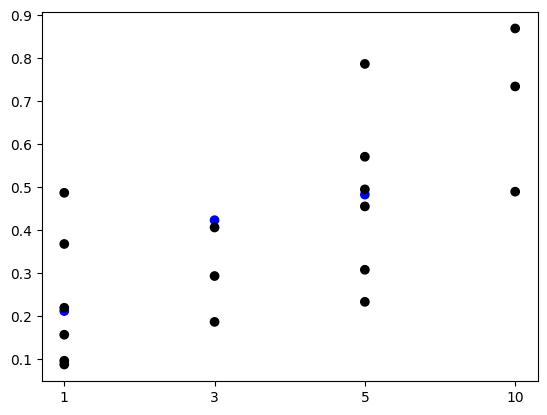

In [6]:
#create scatter plot of assists vs. points
col = np.where(out['Average detection size  '] < 20000, 'k', np.where(out['Average detection size'] > 20000,'b','r'))
fig, ax = plt.subplots()

ax.scatter(out['Frame Rate (fps)'], out['mAP'], c=col)

#label each point in scatter plot
# for idx, row in out.iterrows():
#     ax.annotate(row['Video'], (row['mAP'], row['framerate']), rotation=45)

# Resolution and FPS

In [3]:
res_frame_set = ['largeslow', 'largefast', 'smallslow', 'smallfast']
dir = './test_results/config_testing/framerate/stats'
outputs = []

for f in list(os.listdir(dir)):
    df = pd.read_csv(os.path.join(dir,f), \
                sep=': ', header=None, engine='python').set_index(0)
    df = df.transpose().reset_index(drop=True)
    
    config_params = os.path.basename(os.path.join(dir,f)).split('_')
    df['Video'] = f'{config_params[0]}_{config_params[1]}_{config_params[2]}'
    df['Width (px)'], df['Height (px)'], df['Frame Rate (fps)'] = \
    config_params[1], config_params[2], config_params[3]
    
    outputs.append(df)
        


outputs = pd.concat(outputs)
    
    

In [4]:
outputs

,frames,runtime (inference),average time per frame,runtime (total),energy,avg power,energy per frame,mAP,Video,Width (px),Height (px),Frame Rate (fps)
0,250.0,22.173799,0.088695,42.446342,188.990156,4.452449,0.755961,0.210735,largefast_1280_720,1280,720,1
0,250.0,63.185351,0.252741,83.328845,423.143188,5.077992,1.692573,0.422302,largefast_1280_720,1280,720,3
0,250.0,99.388184,0.397553,119.759623,615.601525,5.140309,2.462406,0.481839,largefast_1280_720,1280,720,5
0,250.0,22.102501,0.088410,42.246308,188.895788,4.471297,0.755583,0.218364,largeslow_1280_720,1280,720,1
0,250.0,63.263542,0.253054,83.593744,420.401967,5.029108,1.681608,0.405322,largeslow_1280_720,1280,720,3
0,250.0,100.345192,0.401381,120.895935,610.975280,5.053729,2.443901,0.494010,largeslow_1280_720,1280,720,5
0,250.0,22.113026,0.088452,42.369368,187.496410,4.425282,0.749986,0.095033,smallfast_1280_720,1280,720,1
0,250.0,62.667291,0.250669,83.127159,421.725943,5.073263,1.686904,0.185492,smallfast_1280_720,1280,720,3
0,250.0,99.645658,0.398583,119.759500,625.305538,5.221344,2.501222,0.232193,smallfast_1280_720,1280,720,5
0,250.0,21.626340,0.086505,41.962143,181.797880,4.332426,0.727192,0.155639,smallslow_1280_720,1280,720,1


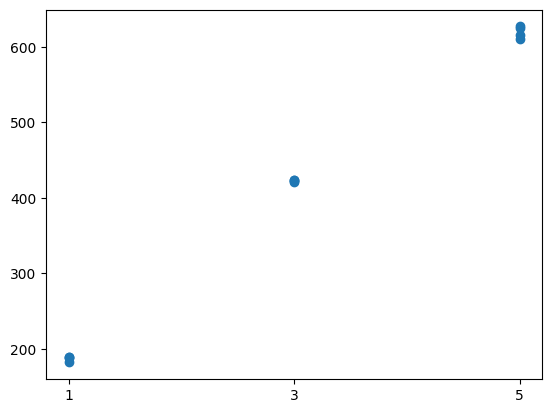

In [8]:
plt.scatter(outputs['Frame Rate (fps)'], outputs['energy'])